In [127]:
#imports
from helper import data_loader, math_helper, k_center
from pyclustering.cluster.kmedians import kmedians
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [128]:
loader = data_loader.data_loader('./config/dataset_config.json')
config = loader.get_config()
dataset_name = "adult"

In [129]:
#load and sample data accorind to the paper

X,_ = loader.load_dataset(dataset_name)
#only return the columns of the protected attribute and the ones necessary for computing the distance
prepared_dataset = loader.prepare_dataset(X, dataset_name)
reds, blues = loader.red_blue_split(prepared_dataset, dataset_name)

#take a sample with size according to the paper
sampled_dataset = loader.sample_data(prepared_dataset, dataset_name, 42)

sampled_reds, sampled_blues = loader.red_blue_split(sampled_dataset, dataset_name)

In [130]:
#some information about the dataset
for sensitive_value in config[dataset_name]['sensitive_values']:
    print("\nAmount of %s values:  %d" %(sensitive_value, X.value_counts(config[dataset_name]['sensitive_column'])[sensitive_value]))

sampled_red_count = len(sampled_reds)
sampled_blue_count = len(sampled_blues)

print("Amount of Male values in sample: " + str(sampled_red_count))
print("Amount of Female values in sample: " + str(sampled_blue_count))

def get_balance(data, sensitive_column):
    return min(data.value_counts(sensitive_column)[0]/data.value_counts(sensitive_column)[1],data.value_counts(sensitive_column)[1]/data.value_counts(sensitive_column)[0])

#output some information about the chosen sample
sample_balance = get_balance(sampled_dataset, config[dataset_name]['sensitive_column'])
print("balance of the chosen sample: " + str(sample_balance))


Amount of Male values:  32650

Amount of Female values:  16192
Amount of Male values in sample: 392
Amount of Female values in sample: 208
balance of the chosen sample: 0.5306122448979592


In [27]:
mathHelper = math_helper.math_helper(loader)
distances = mathHelper.get_distances(sampled_dataset, sampled_blues, sampled_reds, dataset_name)

def create_MCF(distances, clustering_method="k-centers", t=2, T=400, maxCost=1000000):
    #supply = negative demand
    #cost = weight

    G = nx.DiGraph()
    #add special nodes beta and rho and an edge between them
    G.add_node('beta', demand=(-1*sampled_red_count))
    G.add_node('rho', demand=sampled_blue_count)
    G.add_edge('beta','rho', weight=0, capacity=min(sampled_red_count,sampled_blue_count))

    #create a node for each b and r
    for i in range(sampled_blue_count):
        G.add_node('b%d'%(i+1), demand=-1)
        G.add_edge('beta','b%d'%(i+1), weight=0, capacity=t-1)
    for i in range(sampled_red_count):
        G.add_node('r%d'%(i+1), demand=1)
        G.add_edge('r%d'%(i+1), 'rho', weight=0, capacity=t-1)


    #create t' copies of the b and r nodes
    for i in range(sampled_blue_count):
        for extra_node_count in range(t):
            G.add_node('b%d_%d'%(i+1, extra_node_count+1), demand=0)
            G.add_edge('b%d'%(i+1),'b%d_%d'%(i+1,extra_node_count+1), weight=0, capacity=1)
    for i in range(sampled_red_count):
        for extra_node_count in range(t):
            G.add_node('%d_%d'%(i+1, extra_node_count+1), demand=0)
            G.add_edge('r%d_%d'%(i+1, extra_node_count+1), 'r%d'%(i+1), weight=0, capacity=1)

    #add edges between the t' additional b and r nodes
    for i in range(sampled_blue_count):
        for k in range(t):
            for j in range(sampled_red_count):
                for l in range(t):
                    distance = distances[i][j]
                    if(distance <= T):
                        if(clustering_method == "k-centers"):
                            G.add_edge('b%d_%d'%(i+1, k+1), 'r%d_%d'%(j+1, l+1), weight=1, capacity=1)
                        elif(clustering_method == "k-medians"):
                            G.add_edge('b%d_%d'%(i+1, k+1), 'r%d_%d'%(j+1, l+1), weight=distance, capacity=1)
                    else: 
                        G.add_edge('b%d_%d'%(i+1, k+1), 'r%d_%d'%(j+1, l+1), weight=maxCost, capacity=1)

    return G

In [132]:
def get_fairlets(flowDictionary):
    fairlets = []

    for dictKey in flowDictionary.keys():
        if "b" in dictKey and "_" in dictKey:
            if sum(flowDictionary[dictKey].values()) >= 1:
                for r_dictKey in flowDictionary[dictKey].keys():
                    if flowDictionary[dictKey][r_dictKey] == 1:
                        if not any(dictKey.split('_')[0] in d['blues'] for d in fairlets)  and not any(r_dictKey.split('_')[0] in d['reds'] for d in fairlets):
                            fairlets.append({'blues': [dictKey.split('_')[0]], 'reds': [r_dictKey.split('_')[0]]})
                        elif any(dictKey.split('_')[0] in d['blues'] for d in fairlets)  and not any(r_dictKey.split('_')[0] in d['reds'] for d in fairlets):
                            for fairlet in fairlets:
                                if dictKey.split('_')[0] in fairlet['blues']:
                                    fairlet['reds'].append(r_dictKey.split('_')[0])
                        elif not any(dictKey.split('_')[0] in d['blues'] for d in fairlets)  and any(r_dictKey.split('_')[0] in d['reds'] for d in fairlets):
                            for fairlet in fairlets:
                                if r_dictKey.split('_')[0] in fairlet['reds']:
                                    fairlet['blues'].append(dictKey.split('_')[0])

    return fairlets


def get_fairlet_information(flowDictionary):
    fairlets = get_fairlets(flowDictionary)

    fairlet_information = []
    fairlet_centers = []
    fairlet_costs = []

    for fairlet in fairlets:
        fairlet_distances = {}
        distances = []
        for blue in fairlet['blues']:
            for blue2 in fairlet['blues']:
                if blue != blue2:
                    distances.append(mathHelper.compute_distance(sampled_dataset.loc[sampled_blues[int(blue[1:])-1]], sampled_dataset.loc[sampled_blues[int(blue2[1:])-1]], dataset_name=dataset_name))
            for red in fairlet['reds']:
                distances.append(mathHelper.compute_distance(sampled_dataset.loc[sampled_blues[int(blue[1:])-1]], sampled_dataset.loc[sampled_reds[int(red[1:])-1]], dataset_name=dataset_name))
            fairlet_distances[blue] = max(distances)
            distances = []

        for red in fairlet['reds']:
            for blue in fairlet['blues']:
                distances.append(mathHelper.compute_distance(sampled_dataset.loc[sampled_reds[int(red[1:])-1]], sampled_dataset.loc[sampled_blues[int(blue[1:])-1]], dataset_name=dataset_name))
            for red2 in fairlet['reds']:
                if red != red2:
                    distances.append(mathHelper.compute_distance(sampled_dataset.loc[sampled_reds[int(red[1:])-1]], sampled_dataset.loc[sampled_reds[int(red2[1:])-1]], dataset_name=dataset_name))
            fairlet_distances[red] = max(distances)

        center = min(fairlet_distances, key=fairlet_distances.get)
        fairlet_centers.append(center)
        fairlet_costs.append(fairlet_distances[center])
        fairlet_information.append(fairlet_distances)

    return fairlet_information, fairlet_centers, fairlet_costs

def get_fairlet_center_dataframe(center_codes_list, drop=True):
    indices = []
    for fairlet_center_code in center_codes_list:
        if(fairlet_center_code[:1] == 'r'):
            indices.append(sampled_reds[int(fairlet_center_code[1:])-1])
        else:
            indices.append(sampled_blues[int(fairlet_center_code[1:])-1])

    if drop == True:
        return sampled_dataset[sampled_dataset.index.isin(indices)].drop(config[dataset_name]['sensitive_column'], axis=1)
    else:
        return sampled_dataset[sampled_dataset.index.isin(indices)]


In [174]:
def get_cluster_balances(cluster_assignment, clustered_dataset, cluster_count, fair=False):
    cluster_indices = []
    for c in range(cluster_count):
        cluster_indices.append([i for i, n in enumerate(cluster_assignment) if n == c])

    cluster_points = []
    for c in range(cluster_count):
        cluster_points.append(clustered_dataset.iloc[cluster_indices[c]])

    if(fair==True):
        coded_points_fairlets = []
        for fairlet in information:
            coded_points = fairlet.keys()
            fairlet_indices = []
            for coded_point in coded_points:
                if(coded_point[:1] == 'r'):
                    fairlet_indices.append(sampled_reds[int(coded_point[1:])-1])
                else:
                    fairlet_indices.append(sampled_blues[int(coded_point[1:])-1])
            coded_points_fairlets.append(fairlet_indices)

        all_clustered_point_idx = []
        for cluster_point in cluster_points:
            clustered_points = cluster_point.index
            all_points = []
            for point in clustered_points:
                for coded_points_fairlet in coded_points_fairlets:
                    if point in coded_points_fairlet:
                        all_points.append(coded_points_fairlet)
            all_clustered_point_idx.append(all_points)

        all_clustered_point_idx[0]
        all_clustered_points_lists = []
        for all_clustered_point in all_clustered_point_idx:
            all_clustered_points_lists.append([x for xs in all_clustered_point for x in xs])

        clusters = []
        for all_clustered_points_list in all_clustered_points_lists:
            clusters.append(sampled_dataset[sampled_dataset.index.isin(all_clustered_points_list)])

        balances = []
        for cluster in clusters:
            if len(cluster) > 0:
                balances.append(get_balance(cluster, config[dataset_name]['sensitive_column']))
        return balances

    else:
        balances = []
        for cluster in cluster_points:
            if len(cluster) > 0:
                balances.append(get_balance(cluster, config[dataset_name]['sensitive_column']))
        
        return balances

In [164]:
clustering_algorithms = ["k-centers", "k-medians"]

for clustering_algorithm in clustering_algorithms:

    unfair_costs = []
    unfair_balances = []
    fair_costs = []
    fair_balances = []
    max_num_clusters = 20

    G = create_MCF(distances, clustering_algorithm)
    flowCost, flowDictionary = nx.network_simplex(G)
    information, centers, costs = get_fairlet_information(flowDictionary)
    fairlet_center_sampled_dataset = get_fairlet_center_dataframe(centers)
    fairlet_centers_dataset = get_fairlet_center_dataframe(centers, False)
    
    for cluster_count in range(3, max_num_clusters):
        vanilla_cost, vanilla_centers, vanilla_cluster_assignment = k_center.solve_k_centers(sampled_dataset, cluster_count)
        fairlet_cost, fairlet_centers, fairlet_cluster_assignment = k_center.solve_k_centers(fairlet_center_sampled_dataset, cluster_count)

        unfair_costs.append(vanilla_cost)
        unfair_balance = get_cluster_balances(vanilla_cluster_assignment, sampled_dataset, cluster_count, False)
        unfair_balances.append(min(unfair_balance))

        fair_costs.append(fairlet_cost)
        fair_balance = get_cluster_balances(fairlet_cluster_assignment, fairlet_centers_dataset, cluster_count, True)
        fair_balances.append(min(fair_balance))

    



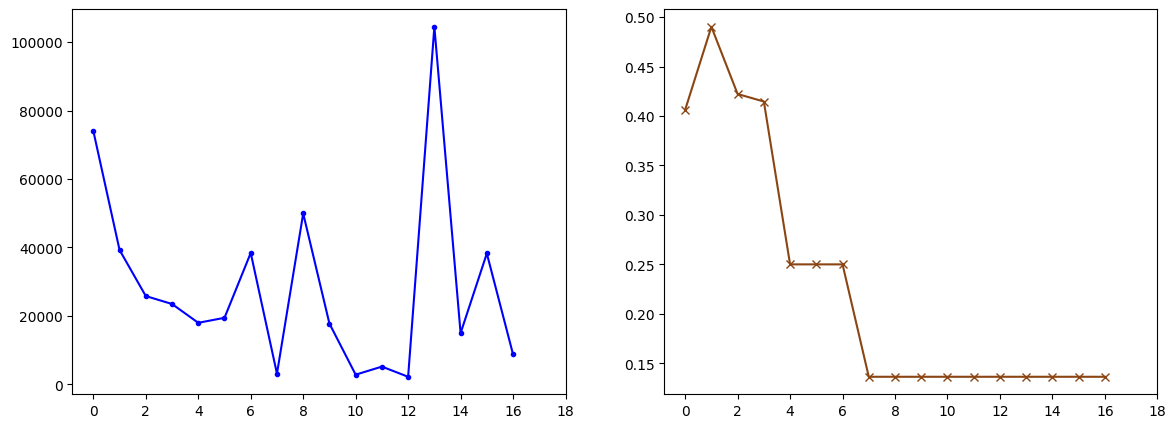

In [172]:
step_size=2
xticks = np.arange(0, 20, 2)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
ax[0].plot(unfair_costs, marker='.', color='blue')
ax[0].set_xticks(xticks) 
ax[1].plot(unfair_balances, marker='x', color='saddlebrown')
ax[1].set_xticks(xticks) 
plt.show()

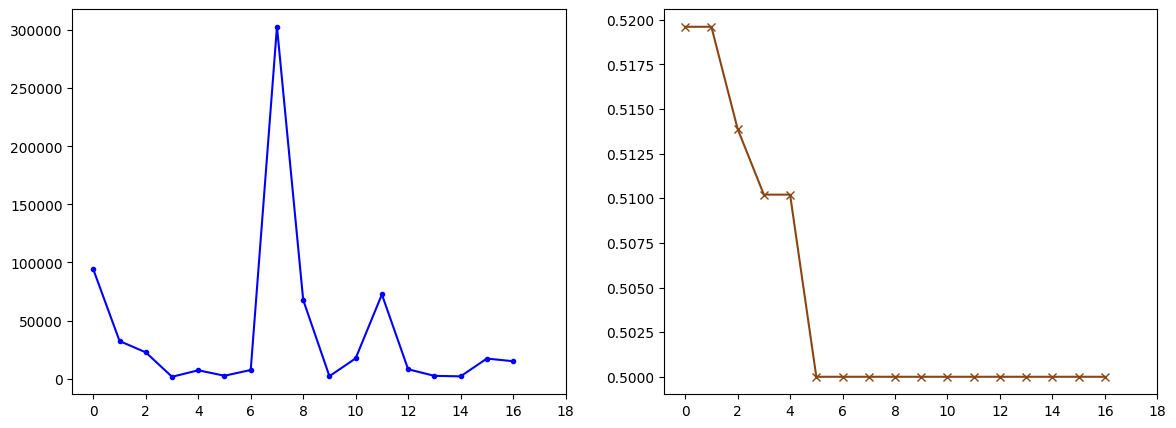

In [173]:
xticks = np.arange(0, 20, 2)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
ax[0].plot(fair_costs, marker='.', color='blue')
ax[0].set_xticks(xticks) 
ax[1].plot(fair_balances, marker='x', color='saddlebrown')
ax[1].set_xticks(xticks) 
plt.show()

In [ ]:
#k-medians
G_k_medians = create_MCF(distances, "k-medians")
flowCost, flowDictionary = nx.network_simplex(G_k_medians)
information, centers, costs = get_fairlet_information(flowDictionary)
fairlet_center_sampled_dataset = get_fairlet_center_dataframe(centers)
fairlet_centers_dataset = get_fairlet_center_dataframe(centers, False)

In [176]:



fairlet_center_sampled_dataset = get_fairlet_center_dataframe(centers)

n_clusters = 5
#vanilla
medians = sampled_dataset.to_numpy()[np.random.choice(range(0, sampled_dataset.shape[0]), size=n_clusters, replace=False)]
kmedians_vanilla = kmedians(sampled_dataset, medians)
kmedians_vanilla.process()
vanilla_clusters = kmedians_vanilla.get_clusters()



#fair
fairlet_medians = fairlet_center_sampled_dataset.to_numpy()[np.random.choice(range(0, fairlet_center_sampled_dataset.shape[0]), size=n_clusters, replace=False)]
kmedians_fairlets = kmedians(fairlet_center_sampled_dataset, fairlet_medians)
kmedians_fairlets.process()
fairlet_clusters = kmedians_fairlets.get_clusters()

kmedians_fairlets.get_cluster_encoding()

<type_encoding.CLUSTER_INDEX_LIST_SEPARATION: 1>